In [2]:
# !pip install snowflake-connector-python cryptography --quiet

from cryptography.hazmat.primitives import serialization
import snowflake.connector

# Load your uploaded private key
with open("/Users/chenx46/Downloads/private_key.pem", "rb") as key_file:
    p_key = serialization.load_pem_private_key(
        key_file.read(),
        password=None  # use password=b"your_password" if your key is encrypted
    )

private_key_bytes = p_key.private_bytes(
    encoding=serialization.Encoding.DER,
    format=serialization.PrivateFormat.PKCS8,
    encryption_algorithm=serialization.NoEncryption()
)

conn = snowflake.connector.connect(
    account = "MARS-MARSSNACKINGDIVISION_US",
    user = "xi.chen3@effem.com",
    role = "SF_MW_HUMAN_INTELLIGENCE_DEVELOPER_WRITE",
    warehouse = "MW_HUMAN_INTELLIGENCE_DATASCIENCE_WH",
    database = "MW_DATALAKE_HUMAN_INTELLIGENCE",
    schema = "PERSISTENT",
    private_key = private_key_bytes)

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime



from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error,accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve,auc,RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from xgboost import plot_tree,plot_importance

# need to install graphviz 
# conda install graphviz python-graphviz


# sql_query = """
# select *
# from MW_DATALAKE_HUMAN_INTELLIGENCE.PERSISTENT.XI_T1_BINARY_SMPL
# """
# sql_query = """
# select *
# from MW_DATALAKE_HUMAN_INTELLIGENCE.PERSISTENT.XI_T1_BINARY
# ORDER BY RANDOM()
# LIMIT 100000
# """
sql_query = """
select *
from 
MW_DATALAKE_HUMAN_INTELLIGENCE.PERSISTENT.XI_T1_BINARY_SMPL

"""
# MW_DATALAKE_HUMAN_INTELLIGENCE.PERSISTENT.XI_T1_BINARY_SMPL


df_cust = pd.read_sql(sql_query, conn)

# Step 1 Train/Test Split
X = df_cust.drop(columns=['TX_SPEND_REC_ID','EPSILON1P_REC_ID','MMSPENT','MMSPENT_RK','MMSPENT_BINARY'])  # Features
y = df_cust['MMSPENT_BINARY']  # Target variable

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)




/var/folders/gm/m1rtxht12_319t38r2lkbd940000gn/T/ipykernel_79671/2927120854.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cust = pd.read_sql(sql_query, conn)


**create shell and run model fit. evaluate the auc using the testing data. And stop building the tree when there is no improvement on thsi number**

In [4]:
clf__xgb=xgb.XGBClassifier(object='binary:logistic',missing=0,seed=42,
early_stopping_rounds=10,
eval_metric='aucpr',
tree_method='hist')
clf__xgb.fit(X_train, y_train,eval_set=[(X_test,y_test)],
verbose=True
)

[0]	validation_0-aucpr:0.52472
[1]	validation_0-aucpr:0.52149
[2]	validation_0-aucpr:0.51967
[3]	validation_0-aucpr:0.51870
[4]	validation_0-aucpr:0.52309
[5]	validation_0-aucpr:0.52035
[6]	validation_0-aucpr:0.52442
[7]	validation_0-aucpr:0.51860
[8]	validation_0-aucpr:0.51624
[9]	validation_0-aucpr:0.51492


/opt/anaconda3/envs/xgboost_env/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [13:34:05] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "object" } are not used.

  self.starting_round = model.num_boosted_rounds()


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,10
,enable_categorical,False
,eval_metric,'aucpr'


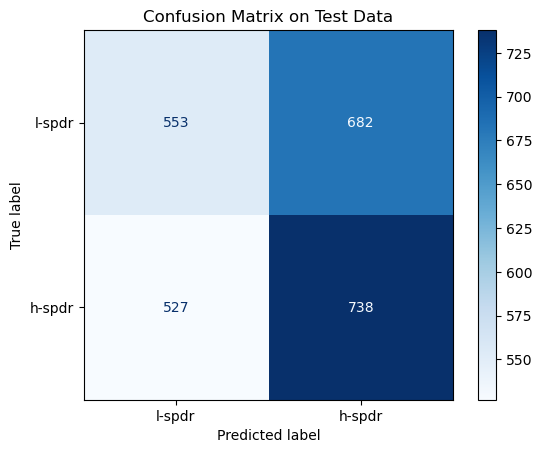

In [5]:
# Make predictions
y_pred = clf__xgb.predict(X_test)
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["l-spdr", "h-spdr"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Data")
plt.show()





run the grid search with cross validation to find the optimal hyperparameters

In [6]:
# Grid search takes about 20 minutes in 8 core GPU
# Grid search takes about 20 minutes in 8 core GPU
# Grid search takes about 11 minutes in # 32 core cpu
# Grid search takes about 11 minutes in # 32 core cpu

# Grid search takes about 5 minutes in # 64 core gpu
# Grid search takes about 5 minutes in # 64 core gpu


# Grid search takes about 35 minutes in # 64 core gpu for 1M reocrds
# Grid search takes about 35 minutes in # 64 core gpu for 1M records



param_grid={
    'max_depth': [3,4,5],
    'learning_rate': [0.1,0.01,0.05],
    'gamma': [0,0.25,1.0],
    'reg_lambda': [0,1.0,10.0],
    'scale_pos_weight': [1,3,5]
}

optimal_params=GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic',
seed=42,
subsample=0.9,
colsample_bytree=0.5),
param_grid=param_grid,
scoring='roc_auc',
verbose=2,
n_jobs=10,
cv=3)

optimal_params.fit(X_train, y_train,eval_set=[(X_test,y_test)],
verbose=True
)
print(optimal_params.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-logloss:0.90282
[0]	validation_0-logloss:0.69239
[1]	validation_0-logloss:0.90885
[1]	validation_0-logloss:0.69173
[2]	validation_0-logloss:0.91534
[2]	validation_0-logloss:0.69147
[0]	validation_0-logloss:0.81218
[3]	validation_0-logloss:0.69154
[3]	validation_0-logloss:0.92049
[0]	validation_0-logloss:0.69266
[1]	validation_0-logloss:0.81346
[4]	validation_0-logloss:0.69123
[4]	validation_0-logloss:0.92562
[2]	validation_0-logloss:0.81413
[0]	validation_0-logloss:0.81201
[1]	validation_0-logloss:0.69261
[5]	validation_0-logloss:0.92942
[3]	validation_0-logloss:0.81519
[0]	validation_0-logloss:0.69268
[0]	validation_0-logloss:0.69244
[0]	validation_0-logloss:0.90218
[6]	validation_0-logloss:0.93334
[5]	validation_0-logloss:0.69053
[1]	validation_0-logloss:0.81288
[4]	validation_0-logloss:0.81579
[1]	validation_0-logloss:0.69261
[2]	validation_0-logloss:0.69246
[1]	validation_0-logloss:0.69189
[5]	validatio

In [7]:
clf__xgb=xgb.XGBClassifier(object='binary:logistic',missing=0,seed=42,
early_stopping_rounds=10,gamma=1,learning_rate=0.01,max_depth=5,reg_lambda=1,
scale_pos_weight=1,subsample=0.9,colsample_bytree=0.5,
eval_metric='aucpr')
clf__xgb.fit(X_train, y_train,eval_set=[(X_test,y_test)],
verbose=True
)

[0]	validation_0-aucpr:0.52695
[1]	validation_0-aucpr:0.52856
[2]	validation_0-aucpr:0.53962
[3]	validation_0-aucpr:0.53941
[4]	validation_0-aucpr:0.54122
[5]	validation_0-aucpr:0.54276
[6]	validation_0-aucpr:0.54059
[7]	validation_0-aucpr:0.54044
[8]	validation_0-aucpr:0.54325
[9]	validation_0-aucpr:0.54309
[10]	validation_0-aucpr:0.54429
[11]	validation_0-aucpr:0.54667
[12]	validation_0-aucpr:0.54698
[13]	validation_0-aucpr:0.54604
[14]	validation_0-aucpr:0.54495
[15]	validation_0-aucpr:0.54554
[16]	validation_0-aucpr:0.54601
[17]	validation_0-aucpr:0.54639
[18]	validation_0-aucpr:0.54515
[19]	validation_0-aucpr:0.54471
[20]	validation_0-aucpr:0.54767


/opt/anaconda3/envs/xgboost_env/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [13:39:05] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "object" } are not used.

  self.starting_round = model.num_boosted_rounds()


[21]	validation_0-aucpr:0.54816
[22]	validation_0-aucpr:0.54502
[23]	validation_0-aucpr:0.54470
[24]	validation_0-aucpr:0.54443
[25]	validation_0-aucpr:0.54519
[26]	validation_0-aucpr:0.54670
[27]	validation_0-aucpr:0.54797
[28]	validation_0-aucpr:0.54841
[29]	validation_0-aucpr:0.54928
[30]	validation_0-aucpr:0.54847
[31]	validation_0-aucpr:0.54955
[32]	validation_0-aucpr:0.54885
[33]	validation_0-aucpr:0.54993
[34]	validation_0-aucpr:0.54974
[35]	validation_0-aucpr:0.54871
[36]	validation_0-aucpr:0.54914
[37]	validation_0-aucpr:0.54855
[38]	validation_0-aucpr:0.54772
[39]	validation_0-aucpr:0.54851
[40]	validation_0-aucpr:0.54882
[41]	validation_0-aucpr:0.54848
[42]	validation_0-aucpr:0.54882


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5
,device,None
,early_stopping_rounds,10
,enable_categorical,False
,eval_metric,'aucpr'
